# Energy Consumption Prediction Project

This notebook loads the UCI household electricity dataset, preprocesses it, and builds forecasting models.

In [31]:
# DATA DOWNLOAD & LOAD
import os
import zipfile
import pandas as pd
from urllib.request import urlretrieve

DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip"
zip_path = os.path.join(DATA_DIR, "household_power_consumption.zip")
csv_name = "household_power_consumption.txt"

if not os.path.exists(zip_path):
    print("Downloading dataset...")
    urlretrieve(url, zip_path)
else:
    print("Dataset already downloaded.")

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(DATA_DIR)

data_path = os.path.join(DATA_DIR, csv_name)
df = pd.read_csv(data_path, sep=';', parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True, na_values=['?'], low_memory=False)
df = df.set_index('datetime').sort_index()
df.head()

Dataset already downloaded.


/tmp/ipython-input-4161060589.py:24: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(data_path, sep=';', parse_dates={'datetime': ['Date', 'Time']},
/tmp/ipython-input-4161060589.py:24: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(data_path, sep=';', parse_dates={'datetime': ['Date', 'Time']},
/tmp/ipython-input-4161060589.py:24: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(data_path, sep=';', parse_dates={'datetime': ['Date', 'Time']},


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [32]:
# Resample to hourly average
df_hour = df[['Global_active_power']].resample('H').mean()
df_hour = df_hour.ffill().bfill()
df_hour = df_hour.rename(columns={'Global_active_power':'GAP_kW'})
df_hour.head()

/tmp/ipython-input-2120826086.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hour = df[['Global_active_power']].resample('H').mean()


,GAP_kW
datetime,
2006-12-16 17:00:00,4.222889
2006-12-16 18:00:00,3.632200
2006-12-16 19:00:00,3.400233
2006-12-16 20:00:00,3.268567
2006-12-16 21:00:00,3.056467


In [33]:
# ✅ FEATURE ENGINEERING (Improved Version)

df_feat = df_hour.copy()

# Time features
df_feat['hour'] = df_feat.index.hour
df_feat['dayofweek'] = df_feat.index.dayofweek
df_feat['month'] = df_feat.index.month
df_feat['is_weekend'] = (df_feat['dayofweek'] >= 5).astype(int)

# ✅ Add Multiple Lag Features
for lag in [1, 2, 3, 6, 12, 24, 48, 72]:   # previous hours / previous day / previous 2-3 days
    df_feat[f'lag_{lag}'] = df_feat['GAP_kW'].shift(lag)

# ✅ Add Rolling Averages (24 hours)
df_feat['roll_mean_24'] = df_feat['GAP_kW'].rolling(window=24).mean().shift(1)
df_feat['roll_std_24'] = df_feat['GAP_kW'].rolling(window=24).std().shift(1)

# Drop rows with missing values from lag/rolling features
df_feat = df_feat.dropna()

df_feat.head()


,GAP_kW,hour,dayofweek,month,is_weekend,lag_1,lag_2,lag_3,lag_6,lag_12,lag_24,lag_48,lag_72,roll_mean_24,roll_std_24
datetime,,,,,,,,,,,,,,,
2006-12-19 17:00:00,2.111500,17,1,12,0,1.372133,0.421367,0.302133,2.321633,0.306667,2.154900,3.406767,4.222889,1.325117,1.048068
2006-12-19 18:00:00,2.204700,18,1,12,0,2.111500,1.372133,0.421367,0.430667,0.796333,2.402533,3.697100,3.632200,1.323308,1.046611
2006-12-19 19:00:00,1.842100,19,1,12,0,2.204700,2.111500,1.372133,0.300467,1.785633,2.614500,2.908400,3.400233,1.315065,1.038489
2006-12-19 20:00:00,2.940533,20,1,12,0,1.842100,2.204700,2.111500,0.302133,3.879033,3.050567,3.361500,3.268567,1.282882,1.007989
2006-12-19 21:00:00,1.442867,21,1,12,0,2.940533,1.842100,2.204700,0.421367,1.617767,2.169733,3.040767,3.056467,1.278297,0.999816


In [34]:
# ✅ DOWNLOAD HOURLY WEATHER DATA FOR BANGALORE (2006–2010)

import pandas as pd

# Bangalore coordinates
lat = 12.9716
lon = 77.5946

weather_url = (
    f"https://archive-api.open-meteo.com/v1/archive?"
    f"latitude={lat}&longitude={lon}&start_date=2006-01-01&end_date=2010-12-31"
    f"&hourly=temperature_2m"
)

print("Downloading weather data...")
weather_df = pd.read_json(weather_url)

# Extract hourly temperature data
weather = pd.DataFrame({
    'datetime': pd.to_datetime(weather_df['hourly']['time']),
    'temperature_C': weather_df['hourly']['temperature_2m']
})

weather = weather.set_index('datetime')
weather = weather.resample('H').mean()   # ensure hourly alignment

print("Weather Data Loaded ✅")
weather.head()


Weather Data Loaded ✅


/tmp/ipython-input-3397108313.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather = weather.resample('H').mean()   # ensure hourly alignment


,temperature_C
datetime,
2006-01-01 00:00:00,13.5
2006-01-01 01:00:00,13.3
2006-01-01 02:00:00,13.3
2006-01-01 03:00:00,15.1
2006-01-01 04:00:00,17.5


In [35]:
# ✅ MERGE WEATHER WITH ENERGY FEATURES
df_feat = df_feat.join(weather, how='inner')

# Drop rows with missing values after merge
df_feat = df_feat.dropna()

df_feat.head()


,GAP_kW,hour,dayofweek,month,is_weekend,lag_1,lag_2,lag_3,lag_6,lag_12,lag_24,lag_48,lag_72,roll_mean_24,roll_std_24,temperature_C
datetime,,,,,,,,,,,,,,,,
2006-12-19 17:00:00,2.111500,17,1,12,0,1.372133,0.421367,0.302133,2.321633,0.306667,2.154900,3.406767,4.222889,1.325117,1.048068,17.2
2006-12-19 18:00:00,2.204700,18,1,12,0,2.111500,1.372133,0.421367,0.430667,0.796333,2.402533,3.697100,3.632200,1.323308,1.046611,16.3
2006-12-19 19:00:00,1.842100,19,1,12,0,2.204700,2.111500,1.372133,0.300467,1.785633,2.614500,2.908400,3.400233,1.315065,1.038489,16.4
2006-12-19 20:00:00,2.940533,20,1,12,0,1.842100,2.204700,2.111500,0.302133,3.879033,3.050567,3.361500,3.268567,1.282882,1.007989,16.4
2006-12-19 21:00:00,1.442867,21,1,12,0,2.940533,1.842100,2.204700,0.421367,1.617767,2.169733,3.040767,3.056467,1.278297,0.999816,16.1


In [36]:
# ✅ TRAIN TEST SPLIT (Final Version including weather)

split_date = "2010-01-01"
train = df_feat.loc[:split_date]
test = df_feat.loc[split_date:]

FEATURES = [col for col in df_feat.columns if col != 'GAP_kW']

X_train = train[FEATURES]
y_train = train['GAP_kW']
X_test = test[FEATURES]
y_test = test['GAP_kW']

print("Total Features Used:", len(FEATURES))
print("Features:", FEATURES)


Total Features Used: 15
Features: ['hour', 'dayofweek', 'month', 'is_weekend', 'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12', 'lag_24', 'lag_48', 'lag_72', 'roll_mean_24', 'roll_std_24', 'temperature_C']


In [37]:
# ✅ XGBoost (Tuned)

from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Scale input features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

model = XGBRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.5,
    reg_alpha=0.1,
    random_state=42,
    tree_method="hist"  # Faster training
)

model.fit(X_train_s, y_train)

y_pred = model.predict(X_test_s)

# Metrics
def mape(y_true, y_pred):
    y_true_arr = np.array(y_true)
    y_pred_arr = np.array(y_pred)
    mask = y_true_arr != 0
    return np.mean(np.abs((y_true_arr[mask] - y_pred_arr[mask]) / y_true_arr[mask])) * 100

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
mape_value = mape(y_test, y_pred)

print("✅ XGBoost Tuned Model Results:")
print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape_value)


✅ XGBoost Tuned Model Results:
MAE: 0.33372242475898
RMSE: 0.4844858938839548
MAPE: 41.42206319169859


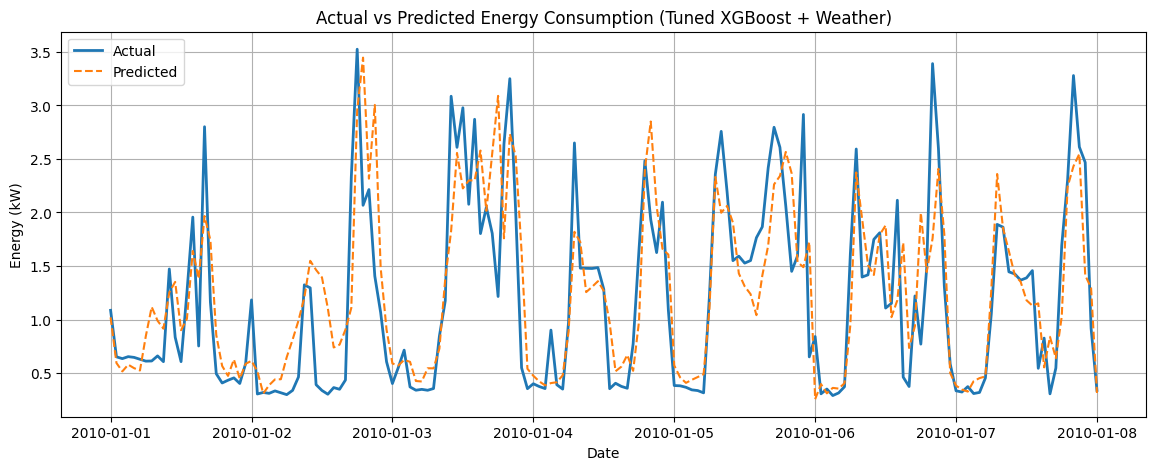

In [38]:
import matplotlib.pyplot as plt

start = test.index[0]
end = start + pd.Timedelta(days=7)

plt.figure(figsize=(14,5))
plt.plot(test.loc[start:end].index, y_test.loc[start:end], label='Actual', linewidth=2)
plt.plot(test.loc[start:end].index, y_pred[:len(test.loc[start:end])], label='Predicted', linestyle='dashed')
plt.title("Actual vs Predicted Energy Consumption (Tuned XGBoost + Weather)")
plt.xlabel("Date")
plt.ylabel("Energy (kW)")
plt.legend()
plt.grid(True)
plt.show()
